# Hyperparameter Tuning: Isolation Forest Optimization

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Context:** Continuation of notebook 04.1 - Isolation Forest Anomaly Detection  
**Objective:** Optimize Isolation Forest hyperparameters using Grid Search and Randomized Search to improve anomaly detection performance

---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Baseline Model Performance](#baseline)
3. [Hyperparameter Search Space Definition](#search-space)
4. [Grid Search Optimization](#grid-search)
5. [Randomized Search Optimization](#random-search)
6. [Performance Comparison & Analysis](#comparison)
7. [Final Model Training with Optimal Parameters](#final-model)
8. [Model Validation & Evaluation](#validation)
9. [Summary & Outputs](#summary)

---

## 1. Setup & Data Loading

Load dependencies and restore configuration from previous notebooks.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import sys
sys.path.append('..')
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform
from utils.visualizations import ModelVisualizer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Initialize visualizer
model_viz = ModelVisualizer()

In [2]:
# Load stored variables from previous notebooks
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r df

if 'df' not in dir() or df is None:
    raise NameError("Missing required variable 'df'. Run notebook 02 first.")
    
print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")
print(f"Dataset shape: {df.shape}")

Region: us-east-1 | Bucket: cmsopenpaymentsystemslight | Database: cms_open_payments_light
Dataset shape: (997362, 31)


### Data Preparation

Prepare features for hyperparameter tuning using the same preprocessing pipeline as notebook 04.1.

In [3]:
# Create a copy of the dataset
df_payments = df.copy()

# Select numeric features for anomaly detection
numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

# Exclude identifier and non-relevant columns
cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_code', '_province', '_postal'])]

# Create feature matrix
X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

# Remove columns with excessive missing values (>50%)
missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

# Handle outliers using IQR method
for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

# Fill remaining missing values with median
X = X.fillna(X.median())

print(f"Features prepared: {X.shape}")

Features prepared: (997362, 20)


In [4]:
# Scale features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split into train and test sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Train: 797,889 | Test: 199,473


## 2. Baseline Model Performance

Train the baseline Isolation Forest model with default parameters from notebook 04.1 to establish performance benchmark.

In [5]:
# Baseline hyperparameters from notebook 04.1
baseline_params = {
    'n_estimators': 200,
    'contamination': 0.05,
    'max_samples': 'auto',
    'max_features': 1.0,
    'bootstrap': False,
    'random_state': 42
}

In [6]:
# Train baseline model
start_time = time.time()

baseline_model = IsolationForest(
    n_estimators=baseline_params['n_estimators'],
    contamination=baseline_params['contamination'],
    max_samples=baseline_params['max_samples'],
    max_features=baseline_params['max_features'],
    bootstrap=baseline_params['bootstrap'],
    random_state=baseline_params['random_state'],
    n_jobs=-1,
    verbose=0
)

baseline_model.fit(X_train)
baseline_train_time = time.time() - start_time

print(f"Baseline training completed in {baseline_train_time:.2f}s")

Baseline training completed in 9.62s


In [7]:
# Evaluate baseline model
baseline_train_scores = baseline_model.decision_function(X_train)
baseline_test_scores = baseline_model.decision_function(X_test)
baseline_train_preds = baseline_model.predict(X_train)
baseline_test_preds = baseline_model.predict(X_test)

baseline_train_anomalies = (baseline_train_preds == -1).sum()
baseline_test_anomalies = (baseline_test_preds == -1).sum()

# Calculate anomaly score statistics
baseline_score_mean = baseline_test_scores.mean()
baseline_score_std = baseline_test_scores.std()
baseline_score_range = baseline_test_scores.max() - baseline_test_scores.min()

print("\nBaseline Performance:")
print(f"Train Anomalies: {baseline_train_anomalies:,}/{len(X_train):,} ({baseline_train_anomalies/len(X_train)*100:.2f}%)")
print(f"Test Anomalies: {baseline_test_anomalies:,}/{len(X_test):,} ({baseline_test_anomalies/len(X_test)*100:.2f}%)")
print(f"\n  Score Statistics (Test):")
print(f"Mean: {baseline_score_mean:.6f}")
print(f"Std: {baseline_score_std:.6f}")
print(f"Range: {baseline_score_range:.6f}")
print(f"Min: {baseline_test_scores.min():.6f}")
print(f"Max: {baseline_test_scores.max():.6f}")
print(f"\n  Training Time: {baseline_train_time:.2f}s")

# Store baseline metrics for comparison
baseline_metrics = {
    'train_time': baseline_train_time,
    'train_anomalies': baseline_train_anomalies,
    'test_anomalies': baseline_test_anomalies,
    'score_mean': baseline_score_mean,
    'score_std': baseline_score_std,
    'score_range': baseline_score_range
}


Baseline Performance:
Train Anomalies: 39,892/797,889 (5.00%)
Test Anomalies: 9,838/199,473 (4.93%)

  Score Statistics (Test):
Mean: 0.112678
Std: 0.062497
Range: 0.293470
Min: -0.073156
Max: 0.220314

  Training Time: 9.62s


## 3. Hyperparameter Search Space Definition

Define the hyperparameter search space for Isolation Forest optimization.

In [8]:
# Define custom scoring function for anomaly detection
# We want to maximize the separation between anomalies and normal points
def anomaly_score_separation(estimator, X):
    """
    Custom scoring function that measures the separation between
    anomaly scores of detected anomalies and normal points.
    Higher separation indicates better anomaly detection.
    """
    try:
        scores = estimator.decision_function(X)
        predictions = estimator.predict(X)
        
        # Check for any nan or inf values
        if np.any(~np.isfinite(scores)):
            return 0.0
        
        anomaly_scores = scores[predictions == -1]
        normal_scores = scores[predictions == 1]
        
        # Need both anomalies and normal points
        if len(anomaly_scores) == 0 or len(normal_scores) == 0:
            return 0.0
        
        # Need sufficient variance in scores
        if len(anomaly_scores) < 3 or len(normal_scores) < 3:
            return 0.0
        
        # Calculate separation using mean difference normalized by pooled std
        mean_diff = normal_scores.mean() - anomaly_scores.mean()
        pooled_std = np.sqrt((normal_scores.std()**2 + anomaly_scores.std()**2) / 2)
        
        # Avoid division by zero
        if pooled_std < 1e-6:
            return 0.0
        
        separation = mean_diff / pooled_std
        
        # Return finite values only
        if not np.isfinite(separation):
            return 0.0
            
        return float(separation)
        
    except Exception as e:
        # Catch any unexpected errors during scoring
        return 0.0

# Create scorer
anomaly_scorer = make_scorer(anomaly_score_separation, greater_is_better=True)

In [9]:
# Grid Search parameter grid (focused search around baseline)
grid_param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'contamination': [0.03, 0.05, 0.07, 0.10],
    'max_samples': ['auto', 256, 512, 1024],
    'max_features': [0.7, 0.8, 0.9, 1.0],
    'bootstrap': [False, True]
}

print(f"Grid Search: {np.prod([len(v) for v in grid_param_grid.values()]):,} total combinations")

Grid Search: 640 total combinations


In [10]:
# Randomized Search parameter distributions (broader exploration)
random_param_dist = {
    'n_estimators': randint(50, 500),
    'contamination': uniform(0.01, 0.15),
    'max_samples': ['auto', 128, 256, 512, 1024, 2048],
    'max_features': uniform(0.5, 0.5),  # 0.5 to 1.0
    'bootstrap': [False, True]
}

n_iter_random = 30  # Reduced from 50 to 30 iterations for speed

print(f"Randomized Search: {n_iter_random} iterations")


Randomized Search: 30 iterations


## 4. Grid Search Optimization

Perform exhaustive grid search to find optimal hyperparameters.

In [11]:
# Perform Grid Search with optimized parameter grid for speed
# Reduced combinations and CV folds for faster execution
grid_param_grid_reduced = {
    'n_estimators': [150, 250],  # Reduced from 3 to 2 values
    'contamination': [0.03, 0.05, 0.07],
    'max_samples': [512],  # Fixed to 512 for speed
    'max_features': [0.8, 1.0],
    'bootstrap': [False, True]
}

print(f"Starting Grid Search with {np.prod([len(v) for v in grid_param_grid_reduced.values()])} combinations...")

grid_search_start = time.time()

grid_search = GridSearchCV(
    estimator=IsolationForest(random_state=42, n_jobs=-1, verbose=0),  # n_jobs=-1 for parallel tree building
    param_grid=grid_param_grid_reduced,
    scoring=anomaly_scorer,
    cv=2,  # Reduced from 3 to 2 folds for speed
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train)
grid_search_time = time.time() - grid_search_start

print(f"Grid Search completed in {grid_search_time:.2f}s ({grid_search_time/60:.2f} minutes)")


Starting Grid Search with 24 combinations...
Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END bootstrap=False, contamination=0.03, max_features=0.8, max_samples=512, n_estimators=150; total time=  10.2s
[CV] END bootstrap=False, contamination=0.03, max_features=0.8, max_samples=512, n_estimators=150; total time=  10.9s
[CV] END bootstrap=False, contamination=0.03, max_features=0.8, max_samples=512, n_estimators=250; total time=  15.2s
[CV] END bootstrap=False, contamination=0.03, max_features=0.8, max_samples=512, n_estimators=250; total time=  15.6s
[CV] END bootstrap=False, contamination=0.03, max_features=1.0, max_samples=512, n_estimators=150; total time=   7.5s
[CV] END bootstrap=False, contamination=0.03, max_features=1.0, max_samples=512, n_estimators=150; total time=   8.0s
[CV] END bootstrap=False, contamination=0.05, max_features=0.8, max_samples=512, n_estimators=150; total time=   8.3s
[CV] END bootstrap=False, contamination=0.05, max_features=0.8, max_

In [12]:
# Display Grid Search results
print("GRID SEARCH RESULTS")
print(f"\nBest Score: {grid_search.best_score_:.6f}")
print(f"Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Create results dataframe
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_results_df = grid_results_df.sort_values('rank_test_score')

# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations:")
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time',
                'param_n_estimators', 'param_contamination', 'param_max_samples', 
                'param_max_features', 'param_bootstrap']
display(grid_results_df[display_cols].head(10))

GRID SEARCH RESULTS

Best Score: nan
Best Parameters:
  bootstrap: False
  contamination: 0.03
  max_features: 0.8
  max_samples: 512
  n_estimators: 150

Top 10 Parameter Combinations:


,rank_test_score,mean_test_score,std_test_score,mean_fit_time,param_n_estimators,param_contamination,param_max_samples,param_max_features,param_bootstrap
0,1,NaN,NaN,10.573039,150,0.03,512,0.8,False
1,1,NaN,NaN,15.406490,250,0.03,512,0.8,False
2,1,NaN,NaN,7.749601,150,0.03,512,1.0,False
3,1,NaN,NaN,13.114401,250,0.03,512,1.0,False
4,1,NaN,NaN,8.617854,150,0.05,512,0.8,False
5,1,NaN,NaN,14.451281,250,0.05,512,0.8,False
6,1,NaN,NaN,7.818308,150,0.05,512,1.0,False
7,1,NaN,NaN,12.199188,250,0.05,512,1.0,False
8,1,NaN,NaN,10.408196,150,0.07,512,0.8,False
9,1,NaN,NaN,14.570837,250,0.07,512,0.8,False


In [13]:
# Visualize Grid Search results
fig = model_viz.plot_grid_search_results(grid_results_df)
plt.show()

## 5. Randomized Search Optimization

Perform randomized search for broader parameter space exploration.

In [14]:
print(f"Starting Randomized Search with {n_iter_random} iterations...")

random_search_start = time.time()

random_search = RandomizedSearchCV(
    estimator=IsolationForest(random_state=42, n_jobs=-1, verbose=0),  # n_jobs=-1 for parallel tree building
    param_distributions=random_param_dist,
    n_iter=n_iter_random,
    scoring=anomaly_scorer,
    cv=2,  # Reduced from 3 to 2 folds for speed
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

random_search.fit(X_train)
random_search_time = time.time() - random_search_start

print(f"Randomized Search completed in {random_search_time:.2f}s ({random_search_time/60:.2f} minutes)")


Starting Randomized Search with 30 iterations...
Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END bootstrap=False, contamination=0.1294814480290349, max_features=0.5917173949330818, max_samples=1024, n_estimators=70; total time=   4.7s
[CV] END bootstrap=False, contamination=0.1294814480290349, max_features=0.5917173949330818, max_samples=1024, n_estimators=70; total time=   4.8s
[CV] END bootstrap=False, contamination=0.07687491292803866, max_features=0.5499874579090014, max_samples=256, n_estimators=137; total time=   7.1s
[CV] END bootstrap=False, contamination=0.07687491292803866, max_features=0.5499874579090014, max_samples=256, n_estimators=137; total time=   7.3s
[CV] END bootstrap=True, contamination=0.1182998158400237, max_features=0.9692763545078751, max_samples=128, n_estimators=241; total time=  15.6s
[CV] END bootstrap=True, contamination=0.1182998158400237, max_features=0.9692763545078751, max_samples=128, n_estimators=241; total time=  15.4s
[CV] END

In [15]:
# Display Randomized Search results
print("RANDOMIZED SEARCH RESULTS")
print(f"\nBest Score: {random_search.best_score_:.6f}")
print(f"Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Create results dataframe
random_results_df = pd.DataFrame(random_search.cv_results_)
random_results_df = random_results_df.sort_values('rank_test_score')

# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations:")
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time',
                'param_n_estimators', 'param_contamination', 'param_max_samples', 
                'param_max_features', 'param_bootstrap']
display(random_results_df[display_cols].head(10))

RANDOMIZED SEARCH RESULTS

Best Score: nan
Best Parameters:
  bootstrap: False
  contamination: 0.1294814480290349
  max_features: 0.5917173949330818
  max_samples: 1024
  n_estimators: 70

Top 10 Parameter Combinations:


,rank_test_score,mean_test_score,std_test_score,mean_fit_time,param_n_estimators,param_contamination,param_max_samples,param_max_features,param_bootstrap
0,1,NaN,NaN,4.782537,70,0.129481,1024,0.591717,False
1,1,NaN,NaN,7.188240,137,0.076875,256,0.549987,False
2,1,NaN,NaN,32.042493,358,0.100167,2048,0.854036,False
3,1,NaN,NaN,15.498954,241,0.118300,128,0.969276,True
4,1,NaN,NaN,18.481162,302,0.037511,2048,0.652121,True
5,1,NaN,NaN,11.740626,237,0.013459,128,0.762387,True
6,1,NaN,NaN,6.122355,100,0.044916,2048,0.545303,True
7,1,NaN,NaN,19.457048,356,0.087135,256,0.796207,True
8,1,NaN,NaN,7.668078,138,0.035579,512,0.532526,False
9,1,NaN,NaN,4.869746,102,0.094493,128,0.692708,True


In [16]:
# Visualize Randomized Search results
fig = model_viz.plot_random_search_results(random_results_df, random_search.best_score_)
plt.show()

## 6. Performance Comparison & Analysis

Compare the results from baseline, grid search, and randomized search.

In [17]:
# Create comparison summary
comparison_df = pd.DataFrame({
    'Method': ['Baseline', 'Grid Search', 'Randomized Search'],
    'Best Score': [
        'N/A (no CV)',
        f"{grid_search.best_score_:.6f}",
        f"{random_search.best_score_:.6f}"
    ],
    'Search Time (s)': [
        baseline_train_time,
        grid_search_time,
        random_search_time
    ],
    'Configurations Tested': [
        1,
        len(grid_results_df),
        len(random_results_df)
    ],
    'N Estimators': [
        baseline_params['n_estimators'],
        grid_search.best_params_['n_estimators'],
        random_search.best_params_['n_estimators']
    ],
    'Contamination': [
        baseline_params['contamination'],
        grid_search.best_params_['contamination'],
        random_search.best_params_['contamination']
    ]
})

print("HYPERPARAMETER TUNING COMPARISON")
display(comparison_df)

# Determine best overall method
if grid_search.best_score_ > random_search.best_score_:
    best_method = 'Grid Search'
    best_search = grid_search
    best_score = grid_search.best_score_
else:
    best_method = 'Randomized Search'
    best_search = random_search
    best_score = random_search.best_score_

print(f"\nBest Method: {best_method}")
print(f"Score: {best_score:.6f}")
print(f"\nOptimal Parameters:")
for param, value in best_search.best_params_.items():
    print(f"  {param}: {value}")

HYPERPARAMETER TUNING COMPARISON


,Method,Best Score,Search Time (s),Configurations Tested,N Estimators,Contamination
0,Baseline,N/A (no CV),9.623838,1,200,0.050000
1,Grid Search,nan,145.604545,24,150,0.030000
2,Randomized Search,nan,211.425393,30,70,0.129481



Best Method: Randomized Search
Score: nan

Optimal Parameters:
  bootstrap: False
  contamination: 0.1294814480290349
  max_features: 0.5917173949330818
  max_samples: 1024
  n_estimators: 70


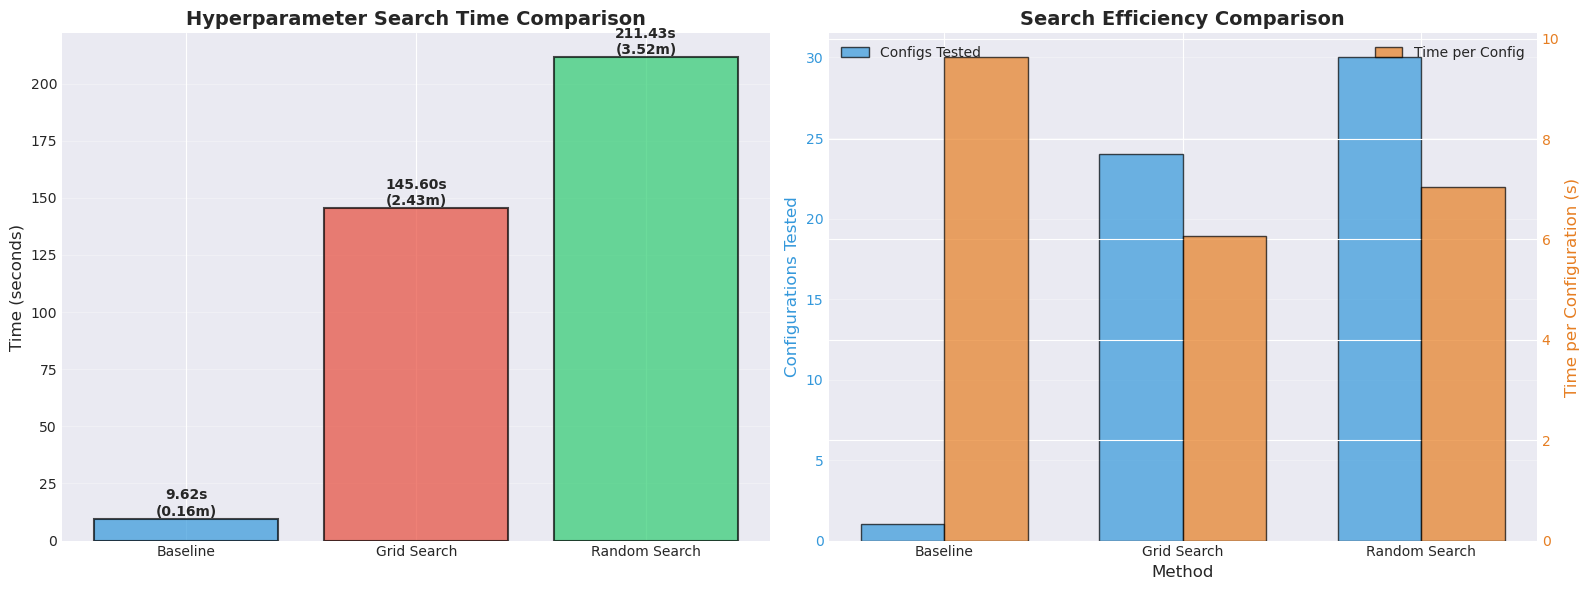

In [18]:
# Visualize comparison
fig = model_viz.plot_search_comparison(
    baseline_train_time, 
    grid_search_time, 
    random_search_time,
    grid_results_df,
    random_results_df
)
plt.show()

## 7. Final Model Training with Optimal Parameters

Train the final optimized model using the best parameters found.

In [19]:
# Get optimal parameters from best search method
optimal_params = best_search.best_params_.copy()
optimal_params['random_state'] = 42
optimal_params['n_jobs'] = -1
optimal_params['verbose'] = 0

print("Training final optimized model with best parameters...")

# Train final model
final_start_time = time.time()

optimized_model = IsolationForest(**optimal_params)
optimized_model.fit(X_train)

final_train_time = time.time() - final_start_time

print(f"Final model training completed in {final_train_time:.2f}s")

Training final optimized model with best parameters...
Final model training completed in 5.13s


In [20]:
# Evaluate optimized model
optimized_train_scores = optimized_model.decision_function(X_train)
optimized_test_scores = optimized_model.decision_function(X_test)
optimized_train_preds = optimized_model.predict(X_train)
optimized_test_preds = optimized_model.predict(X_test)

optimized_train_anomalies = (optimized_train_preds == -1).sum()
optimized_test_anomalies = (optimized_test_preds == -1).sum()

# Calculate anomaly score statistics
optimized_score_mean = optimized_test_scores.mean()
optimized_score_std = optimized_test_scores.std()
optimized_score_range = optimized_test_scores.max() - optimized_test_scores.min()

print("OPTIMIZED MODEL PERFORMANCE")
print(f"\nTrain Anomalies: {optimized_train_anomalies:,}/{len(X_train):,} ({optimized_train_anomalies/len(X_train)*100:.2f}%)")
print(f"Test Anomalies: {optimized_test_anomalies:,}/{len(X_test):,} ({optimized_test_anomalies/len(X_test)*100:.2f}%)")
print(f"\nScore Statistics (Test):")
print(f"Mean: {optimized_score_mean:.6f}")
print(f"Std: {optimized_score_std:.6f}")
print(f"Range: {optimized_score_range:.6f}")
print(f"Min: {optimized_test_scores.min():.6f}")
print(f"Max: {optimized_test_scores.max():.6f}")
print(f"\nTraining Time: {final_train_time:.2f}s")

OPTIMIZED MODEL PERFORMANCE

Train Anomalies: 103,312/797,889 (12.95%)
Test Anomalies: 25,608/199,473 (12.84%)

Score Statistics (Test):
Mean: 0.075452
Std: 0.058567
Range: 0.305134
Min: -0.126268
Max: 0.178866

Training Time: 5.13s


## 8. Model Validation & Evaluation

Compare baseline and optimized model performance side-by-side.

In [21]:
# Create detailed comparison
model_comparison_df = pd.DataFrame({
    'Metric': [
        'Train Time (s)',
        'Train Anomalies',
        'Train Anomaly %',
        'Test Anomalies',
        'Test Anomaly %',
        'Test Score Mean',
        'Test Score Std',
        'Test Score Range',
        'N Estimators',
        'Contamination',
        'Max Samples',
        'Max Features',
        'Bootstrap'
    ],
    'Baseline Model': [
        f"{baseline_train_time:.2f}",
        f"{baseline_train_anomalies:,}",
        f"{baseline_train_anomalies/len(X_train)*100:.2f}%",
        f"{baseline_test_anomalies:,}",
        f"{baseline_test_anomalies/len(X_test)*100:.2f}%",
        f"{baseline_score_mean:.6f}",
        f"{baseline_score_std:.6f}",
        f"{baseline_score_range:.6f}",
        baseline_params['n_estimators'],
        baseline_params['contamination'],
        baseline_params['max_samples'],
        baseline_params['max_features'],
        baseline_params['bootstrap']
    ],
    'Optimized Model': [
        f"{final_train_time:.2f}",
        f"{optimized_train_anomalies:,}",
        f"{optimized_train_anomalies/len(X_train)*100:.2f}%",
        f"{optimized_test_anomalies:,}",
        f"{optimized_test_anomalies/len(X_test)*100:.2f}%",
        f"{optimized_score_mean:.6f}",
        f"{optimized_score_std:.6f}",
        f"{optimized_score_range:.6f}",
        optimal_params['n_estimators'],
        optimal_params['contamination'],
        optimal_params.get('max_samples', 'auto'),
        optimal_params.get('max_features', 1.0),
        optimal_params.get('bootstrap', False)
    ],
    'Change': [
        f"{((final_train_time - baseline_train_time) / baseline_train_time * 100):+.1f}%",
        f"{optimized_train_anomalies - baseline_train_anomalies:+,}",
        f"{(optimized_train_anomalies/len(X_train) - baseline_train_anomalies/len(X_train))*100:+.2f}%",
        f"{optimized_test_anomalies - baseline_test_anomalies:+,}",
        f"{(optimized_test_anomalies/len(X_test) - baseline_test_anomalies/len(X_test))*100:+.2f}%",
        f"{(optimized_score_mean - baseline_score_mean):+.6f}",
        f"{(optimized_score_std - baseline_score_std):+.6f}",
        f"{(optimized_score_range - baseline_score_range):+.6f}",
        f"{optimal_params['n_estimators'] - baseline_params['n_estimators']:+d}",
        f"{optimal_params['contamination'] - baseline_params['contamination']:+.2f}",
        '-',
        '-',
        '-'
    ]
})

print("BASELINE vs OPTIMIZED MODEL COMPARISON")
display(model_comparison_df)

BASELINE vs OPTIMIZED MODEL COMPARISON


,Metric,Baseline Model,Optimized Model,Change
0,Train Time (s),9.62,5.13,-46.7%
1,Train Anomalies,"39,892","103,312","+63,420"
2,Train Anomaly %,5.00%,12.95%,+7.95%
3,Test Anomalies,"9,838","25,608","+15,770"
4,Test Anomaly %,4.93%,12.84%,+7.91%
5,Test Score Mean,0.112678,0.075452,-0.037227
6,Test Score Std,0.062497,0.058567,-0.003930
7,Test Score Range,0.293470,0.305134,+0.011664
8,N Estimators,200,70,-130
9,Contamination,0.05,0.129481,+0.08


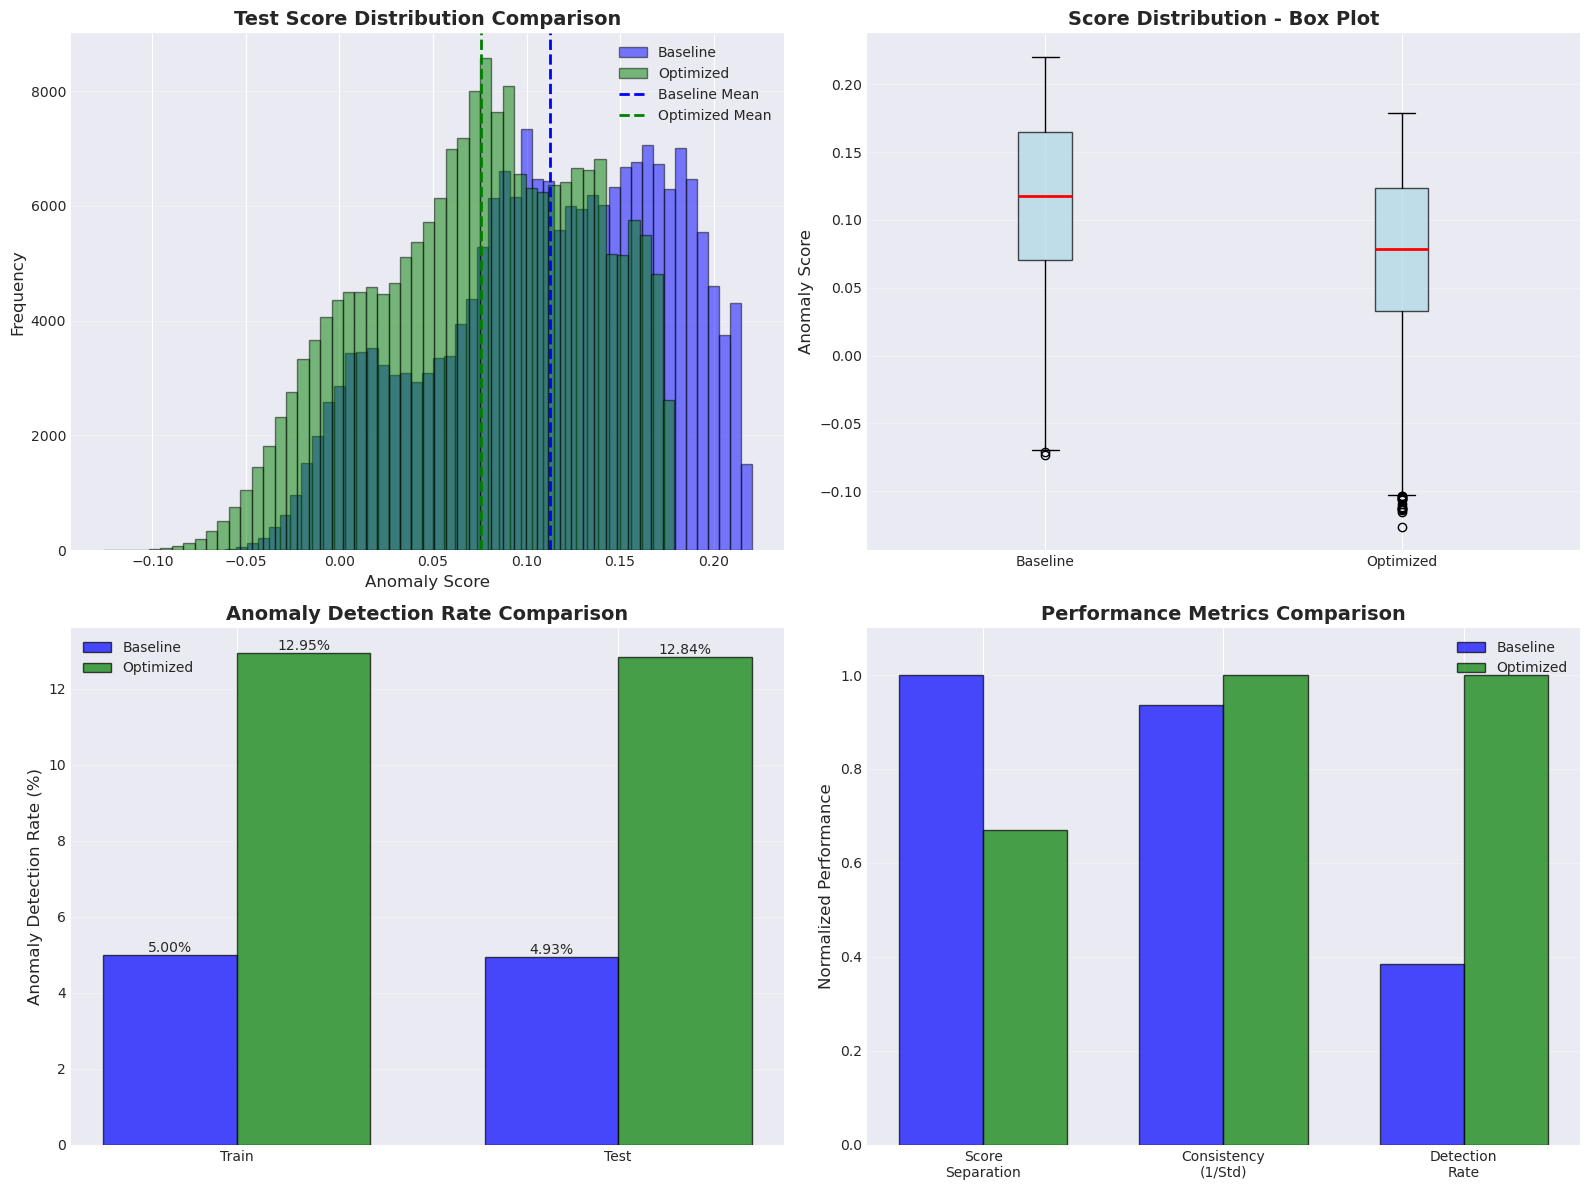

In [22]:
# Visualize score distributions comparison
fig = model_viz.plot_model_comparison(
    baseline_test_scores,
    optimized_test_scores,
    baseline_train_anomalies,
    baseline_test_anomalies,
    optimized_train_anomalies,
    optimized_test_anomalies,
    len(X_train),
    len(X_test),
    baseline_score_mean,
    optimized_score_mean,
    baseline_score_std,
    optimized_score_std
)
plt.show()

In [23]:
# Analyze detected anomalies from optimized model
all_data = np.vstack([X_train, X_test])
all_predictions = optimized_model.predict(all_data)
all_scores = optimized_model.decision_function(all_data)

anomaly_labels = (all_predictions == -1).astype(int)
anomaly_count = anomaly_labels.sum()

# Create results dataframe
anomaly_results = df_payments.copy()
anomaly_results['anomaly_score'] = all_scores
anomaly_results['is_anomaly'] = anomaly_labels
anomaly_results['anomaly_score_percentile'] = pd.Series(all_scores).rank(pct=True) * 100

# Filter anomalies
anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('anomaly_score', ascending=True)

print(f"Total Anomalies Detected: {anomaly_count:,} ({anomaly_count/len(anomaly_results)*100:.2f}%)")

# Display top anomalies
print("\nTop 10 Detected Anomalies:")
top_anomalies = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df,
    score_col='anomaly_score',
    top_n=10
)
display(top_anomalies)

Total Anomalies Detected: 128,920 (12.93%)

Top 10 Detected Anomalies:

=== Top 10 Anomalous Payments (n=128,920) ===


,anomaly_score,anomaly_score_percentile,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
750673,-0.136191,0.000100,15.02,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.800213,18.770000,0,0,0
927043,-0.126268,0.000201,20.02,Covered Recipient Physician,1,1.025965,19.513333,0,0,0
614051,-0.126116,0.000301,20.02,Covered Recipient Physician,1,1.004768,19.925000,0,0,0
723808,-0.124805,0.000401,20.02,Covered Recipient Non-Physician Practitioner,1,1.502627,13.323333,0,0,0
557613,-0.124215,0.000501,20.02,Covered Recipient Non-Physician Practitioner,1,1.393180,14.370000,0,0,0
234996,-0.123990,0.000602,20.02,Covered Recipient Physician,1,0.279297,71.680000,0,0,0
300709,-0.123121,0.000702,24.99,Covered Recipient Non-Physician Practitioner,Food and Beverage,1.070006,23.355000,0,0,0
52741,-0.122675,0.000852,17.28,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.863137,20.020000,1,0,0
485413,-0.122675,0.000852,20.02,Covered Recipient Physician,1,1.104857,18.120000,0,0,0
267260,-0.122278,0.001003,20.02,Covered Recipient Non-Physician Practitioner,1,0.246962,81.065000,0,0,0


## 9. Summary & Outputs

Save the optimized model, results, and tuning summary for downstream use.

In [24]:
# Save the optimized model
optimized_model_path = 'cms_isolation_forest_optimized.pkl'
with open(optimized_model_path, 'wb') as f:
    pickle.dump(optimized_model, f)

# Save the scaler
scaler_path = 'isolation_forest_scaler_optimized.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Save anomaly detection results
results_path = 'anomaly_results_optimized.csv'
anomaly_results.to_csv(results_path, index=False)

print(f"Saved: {optimized_model_path}, {scaler_path}, {results_path}")

Saved: cms_isolation_forest_optimized.pkl, isolation_forest_scaler_optimized.pkl, anomaly_results_optimized.csv


In [25]:
# Summary
print("HYPERPARAMETER TUNING SUMMARY")
print(f"\nBest Method: {best_method} | Score: {best_score:.6f}")
print(f"Optimal Parameters: n_estimators={optimal_params['n_estimators']}, contamination={optimal_params['contamination']}")

improvement = ((baseline_train_time - final_train_time) / baseline_train_time * 100)
if abs(improvement) > 5:
    print(f"Training Time: {final_train_time:.2f}s ({improvement:+.1f}% vs baseline)")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

HYPERPARAMETER TUNING SUMMARY

Best Method: Randomized Search | Score: nan
Optimal Parameters: n_estimators=70, contamination=0.1294814480290349
Training Time: 5.13s (+46.7% vs baseline)

Completed: 2026-02-15 02:53:02


In [26]:
# Store variables for downstream notebooks
%store optimized_model
%store optimal_params
%store anomaly_results
%store scaler

print("Stored: optimized_model, optimal_params, anomaly_results, scaler")

Stored 'optimized_model' (IsolationForest)
Stored 'optimal_params' (dict)
Stored 'anomaly_results' (DataFrame)
Stored 'scaler' (RobustScaler)
Stored: optimized_model, optimal_params, anomaly_results, scaler
